In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter


import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from plotcm import plot_confusion_matrix

import pdb

torch.set_printoptions(linewidth=120)

/Users/martinferianc/.pyenv/versions/3.6.4/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/martinferianc/.pyenv/versions/3.6.4/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/martinferianc/.pyenv/versions/3.6.4/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

### Loading data

torch.utils.data.Dataset	An abstract class for representing a dataset.

torch.utils.data.DataLoader	Wraps a dataset and provides access to the underlying data.

An abstract class is a Python class that has methods we must implement, so we can create a custom dataset by creating a subclass that extends the functionality of the Dataset class.

To create a custom dataset using PyTorch, we extend the Dataset class by creating a subclass that implements these required methods. Upon doing this, our new subclass can then be passed to the a PyTorch DataLoader object.

We will be using the fashion-MNIST dataset that comes built-in with the torchvision package, so we won’t have to do this for our project. Just know that the Fashion-MNIST built-in dataset class is doing this behind the scenes.

All subclasses of the Dataset class must override __len__, that provides the size of the dataset, and __getitem__, supporting integer indexing in range from 0 to len(self) exclusive.
Specifically, there are two methods that are required to be implemented. The __len__ method which returns the length of the dataset, and the __getitem__ method that gets an element from the dataset at a specific index location within the dataset.

In [2]:
# Get the dataset
batch_size = 64
train_set = torchvision.datasets.FashionMNIST(
    root='../data'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
#        transforms.Normalize(mean=0, std =1)
    ])
)
train_loader = torch.utils.data.DataLoader(train_set
    ,batch_size=batch_size
    ,shuffle=False
)
test_set = torchvision.datasets.FashionMNIST(
    root='../data'
    ,train=False
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
#        transforms.Normalize(mean=0, std =1)
    ])
)
test_loader = torch.utils.data.DataLoader(test_set
    ,batch_size=batch_size
    ,shuffle=False
)

In [3]:
# Get the train and test set lengths
print(len(train_set), len(test_set))

60000 10000


In [4]:
# Print out the counts in the each lass and how to access the albels
print(train_set.targets, test_set.targets)
print(train_set.targets.bincount(), test_set.targets.bincount())

tensor([9, 0, 0,  ..., 3, 0, 5]) tensor([9, 2, 1,  ..., 8, 1, 5])
tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]) tensor([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])


In [5]:
# Access a single sample, beware that it is necesary to use iter()
sample = next(iter(train_set))
len(sample)

2

In [6]:
image, label = sample
print(image.shape,label)
image = image.squeeze()
print(image.shape)

torch.Size([1, 28, 28]) 9
torch.Size([28, 28])


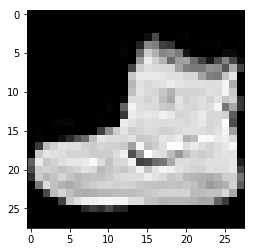

In [7]:
plt.imshow(image, cmap="gray")

In [8]:
batch = next(iter(train_loader))
print(len(batch))

2


In [9]:
images, labels = batch
print(images.shape,labels.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


labels: tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5])


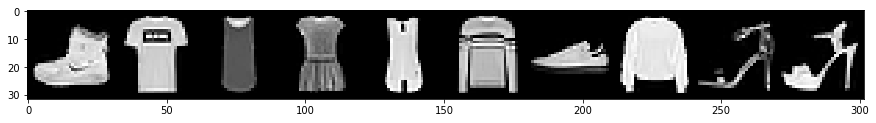

In [10]:
# To plot the images we can use toruch in-built fuction to make a nice grid
grid = torchvision.utils.make_grid(images[:10], nrow=10)

plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))

print('labels:', labels[:10])

In [11]:
# Network
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12 * 4 * 4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, t):
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size = 2, stride = 2)
        
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size = 2, stride = 2)
        
        t = t.flatten(start_dim=1)
        t = self.fc1(t)
        t = F.relu(t)
        t = self.fc2(t)
        t = F.relu(t)
        t = self.out(t)
        #t = F.softmax(t) Won't use because when we do the loss it has a built in softmax
        return t

In [12]:
network = Network()
print(network)

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)


In [13]:
# Access a single layer
print(network.conv1)

Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))


In [14]:
print(network.conv1.weight)
#One thing to notice about the weight tensor output is that it says parameter 
#containing at the top of the output. This is because this particular tensor is 
#a special tensor because its values or scalar components are learnable parameters of our network.
print(network.conv1.weight.shape)
# Number of output feature maps x number of input feature maps x kernel size x kernel size

Parameter containing:
tensor([[[[ 0.0759,  0.0802,  0.0418,  0.1764,  0.0311],
          [ 0.0554,  0.0631, -0.1547,  0.0894, -0.0157],
          [ 0.0831,  0.1207,  0.1702,  0.1341, -0.1575],
          [ 0.0589,  0.1435, -0.0736, -0.1265, -0.1587],
          [-0.0589,  0.0029,  0.1909,  0.0114,  0.1146]]],


        [[[ 0.1291, -0.0136, -0.1108, -0.1942,  0.1958],
          [-0.1906,  0.1129, -0.0714,  0.0889, -0.1435],
          [ 0.1412,  0.0661,  0.1334,  0.0885, -0.0547],
          [ 0.1276, -0.1281, -0.0824,  0.1693, -0.1769],
          [ 0.0204, -0.0923,  0.0070,  0.0125, -0.1310]]],


        [[[ 0.1575,  0.1274, -0.0969, -0.0979, -0.1791],
          [-0.0698,  0.0023,  0.1043,  0.0129, -0.1337],
          [ 0.0334,  0.0590, -0.0065, -0.1501,  0.1257],
          [-0.1655,  0.1244,  0.0716, -0.0764,  0.0488],
          [ 0.0255,  0.0384,  0.1951,  0.0677,  0.1922]]],


        [[[ 0.1375,  0.0946, -0.0651, -0.0631,  0.1881],
          [-0.1094, -0.0133, -0.1736, -0.0059, -0.0337

In [15]:
# Access the parameters
for param in network.parameters():
    print(param.shape)

torch.Size([6, 1, 5, 5])
torch.Size([6])
torch.Size([12, 6, 5, 5])
torch.Size([12])
torch.Size([120, 192])
torch.Size([120])
torch.Size([60, 120])
torch.Size([60])
torch.Size([10, 60])
torch.Size([10])


#### Definition of a Linear class (an example) taken directly from the PyTorch class
```python
def __init__(self, in_features, out_features, bias=True):
    super(Linear, self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.weight = Parameter(torch.Tensor(out_features, in_features))
    if bias:
        self.bias = Parameter(torch.Tensor(out_features))
    else:
        self.register_parameter('bias', None)
    self.reset_parameters()
```

Instead of calling the forward() method directly, we call the object instance. After the object instance is called, the __call__() method is invoked under the hood, and the __call__() in turn invokes the forward() method. This applies to all PyTorch neural network modules, namely, networks and layers.



In [16]:
# Disable the gradient computation and creation of the dynamic graph
torch.set_grad_enabled(False) 

In [17]:
sample = next(iter(train_set)) 
image, label = sample 
image.shape

image = image.unsqueeze(dim=0)
prediction = network(image)

In [18]:
batch = next(iter(train_loader))
images, labels = batch
predictions = network(images)
print(labels)
print(prediction.argmax(dim=1))
print(predictions.argmax(dim=1).eq(labels).sum().item())

tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1, 4, 8, 4, 3, 0, 2, 4, 4, 5, 3, 6, 6, 0, 8, 5,
        2, 1, 6, 6, 7, 9, 5, 9, 2, 7, 3, 0, 3, 3, 3, 7, 2, 2, 6, 6, 8, 3, 3, 5, 0, 5, 5])
tensor([7])
5


In [19]:
# To enable training
torch.set_grad_enabled(True)

In [20]:
# Training on a single batch
"""
optimizer = optim.Adam(network.parameters(), lr=0.01)

batch = next(iter(train_loader)) # Get Batch
images, labels = batch

preds = network(images) # Pass Batch
loss = F.cross_entropy(preds, labels) # Calculate Loss

loss.backward() # Calculate Gradients
optimizer.step() # Update Weights

print('loss1:', loss.item())
preds = network(images)
loss = F.cross_entropy(preds, labels)
print('loss2:', loss.item())
"""

# Training in a loop
network = Network()
optimizer = optim.Adam(network.parameters(), lr=0.01)

images, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(images)

tb = SummaryWriter()
tb.add_image('images', grid)
tb.add_graph(network, images)

epochs = 5

for epoch in range(epochs):
    total_loss = 0
    total_correct = 0
    for batch in train_loader: # Get Batch
        images, labels = batch 

        preds = network(images) # Pass Batch
        loss = F.cross_entropy(preds, labels) # Calculate Loss

        optimizer.zero_grad()
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item() * batch_size
        total_correct += preds.argmax(dim=1).eq(labels).sum().item()
        
    tb.add_scalar('Loss', total_loss, epoch)
    tb.add_scalar('Number Correct', total_correct, epoch)
    tb.add_scalar('Accuracy', total_correct / len(train_set), epoch)

    tb.add_histogram('conv1.bias', network.conv1.bias, epoch)
    tb.add_histogram('conv1.weight', network.conv1.weight, epoch)
    tb.add_histogram(
        'conv1.weight.grad'
        ,network.conv1.weight.grad
        ,epoch
    )
    
    print(
        "epoch:", epoch, 
        "total_correct:", total_correct/len(train_set), 
        "loss:", total_loss
    )

epoch: 0 total_correct: 0.7972166666666667 loss: 32389.102977752686
epoch: 1 total_correct: 0.8570333333333333 loss: 23512.378125190735
epoch: 2 total_correct: 0.866 loss: 21771.240087509155
epoch: 3 total_correct: 0.8717166666666667 loss: 20938.141308307648
epoch: 4 total_correct: 0.8759833333333333 loss: 20339.56377887726


In [21]:
# Get the predictions to build the confusion matrix
# To disabl ethe gradient we can also do: with torch.no_grad():
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

predictions = get_all_preds(network,train_loader)
total_correct = predictions.argmax(dim=1).eq(train_set.targets).sum().item()/len(train_loader)
print(total_correct)

55.81663113006397


In [22]:
stacked = torch.stack(
    (
        train_set.targets
        ,predictions.argmax(dim=1)
    )
    ,dim=1
)


print(stacked.shape)
print(stacked)

torch.Size([60000, 2])
tensor([[9, 9],
        [0, 0],
        [0, 0],
        ...,
        [3, 3],
        [0, 0],
        [5, 5]])


In [23]:
cmt = torch.zeros(10,10, dtype=torch.int64)
for p in stacked:
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1
print(cmt)
# Another option
cm = confusion_matrix(train_set.targets, predictions.argmax(dim=1))
print(cm) # This is going to be a numpy array

tensor([[5378,    3,   94,   70,   16,    1,  386,    0,   52,    0],
        [  41, 5826,    4,  110,    0,    0,   10,    0,    9,    0],
        [  55,    4, 4106,   63, 1241,    1,  496,    0,   34,    0],
        [ 287,   17,   19, 5440,  116,    0,  114,    0,    7,    0],
        [  15,    1,  156,  333, 5043,    1,  433,    0,   18,    0],
        [   3,    0,    0,   11,    2, 5554,    0,  285,   66,   79],
        [1209,    4,  460,  121,  523,    0, 3582,    0,  101,    0],
        [   0,    0,    0,    1,    0,   12,    0, 5841,   20,  126],
        [  22,    0,    9,   29,   35,    1,   35,    1, 5865,    3],
        [   2,    0,    0,    5,    0,   31,    1,  233,    7, 5721]])
[[5378    3   94   70   16    1  386    0   52    0]
 [  41 5826    4  110    0    0   10    0    9    0]
 [  55    4 4106   63 1241    1  496    0   34    0]
 [ 287   17   19 5440  116    0  114    0    7    0]
 [  15    1  156  333 5043    1  433    0   18    0]
 [   3    0    0   11    2 5554   

Confusion matrix, without normalization
[[5378    3   94   70   16    1  386    0   52    0]
 [  41 5826    4  110    0    0   10    0    9    0]
 [  55    4 4106   63 1241    1  496    0   34    0]
 [ 287   17   19 5440  116    0  114    0    7    0]
 [  15    1  156  333 5043    1  433    0   18    0]
 [   3    0    0   11    2 5554    0  285   66   79]
 [1209    4  460  121  523    0 3582    0  101    0]
 [   0    0    0    1    0   12    0 5841   20  126]
 [  22    0    9   29   35    1   35    1 5865    3]
 [   2    0    0    5    0   31    1  233    7 5721]]


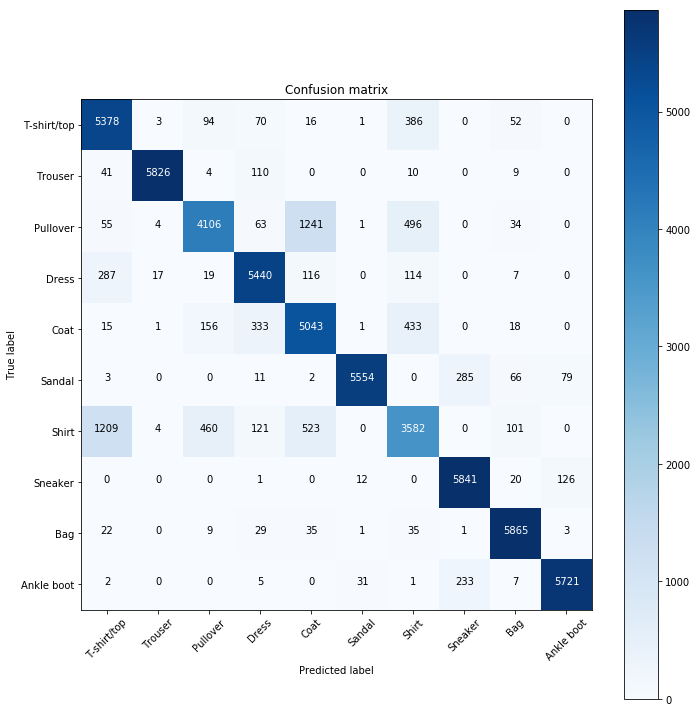

In [24]:
names = (
    'T-shirt/top'
    ,'Trouser'
    ,'Pullover'
    ,'Dress'
    ,'Coat'
    ,'Sandal'
    ,'Shirt'
    ,'Sneaker'
    ,'Bag'
    ,'Ankle boot'
)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names)

In [25]:
# Use tensorboard to visualise everything 
tb = SummaryWriter()

network = Network()
images, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(images)

tb.add_image('images', grid)
tb.add_graph(network, images)
tb.close()